# Least Squares Fitting Package

This notebook provides a compact package for doing least squares fitting of your data. 

You can copy this code by cutting and pasting the whole cell containing the code. In addition to defining new fitting functions ("DEFINED FITTING FUNCTIONS"), you will typically need to update or modify the information contained in "LIST OF ALL INPUTS":
* `fname` to load the correct data file
* `x_name`, `x_units`, `y_name` and `y_units` to match your data file
* `fit_function = ..` to use your defined fitting function
* `param_names` and `guesses`: these MUST match the parameters in the defined fitting function that follow after (x,...)
* Update any of the optional features flags as desired

### Data file format 
* `fname` is assumed to be in a four-column .csv file.
* In the following code, `skiprows=2` indicates that the first two rows in `fname` are headers (names and units)

<center>data = np.loadtxt(fname, .. , skiprows=2)</center>

* The four columns are x-values, x-uncertainties, y-values, y-uncertainties.
* The .csv file must be in the same folder as notebook. otherwise the full file extension must be added
to fname: e.g. fname = 'folder/subfolder/subsubfolder/file.csv'

Matplotlib is building the font cache; this may take a moment.
Fontconfig warning: ignoring UTF-8: not a valid region tag


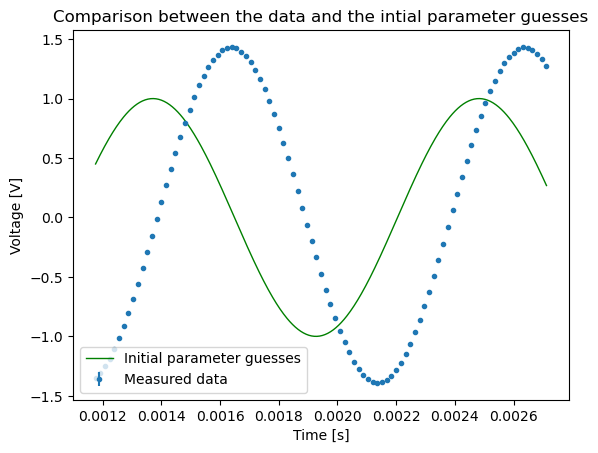

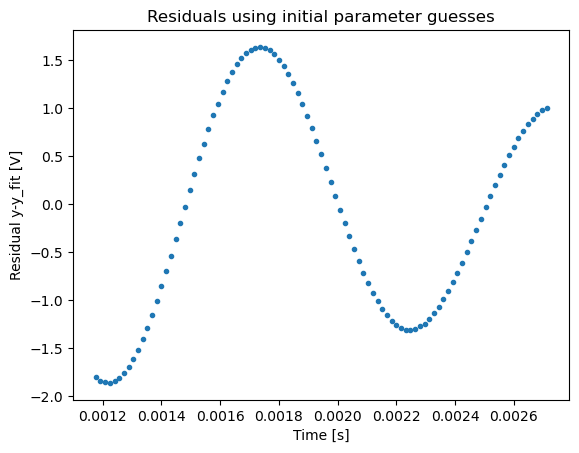

Chi-squared =  191.42167854188855

Fit parameters:
   amplitude = 1.413e+00 ± 1.855e-04
   frequency = 9.996e+02 ± 5.057e-02
   phase = -2.423e+00 ± 6.170e-04




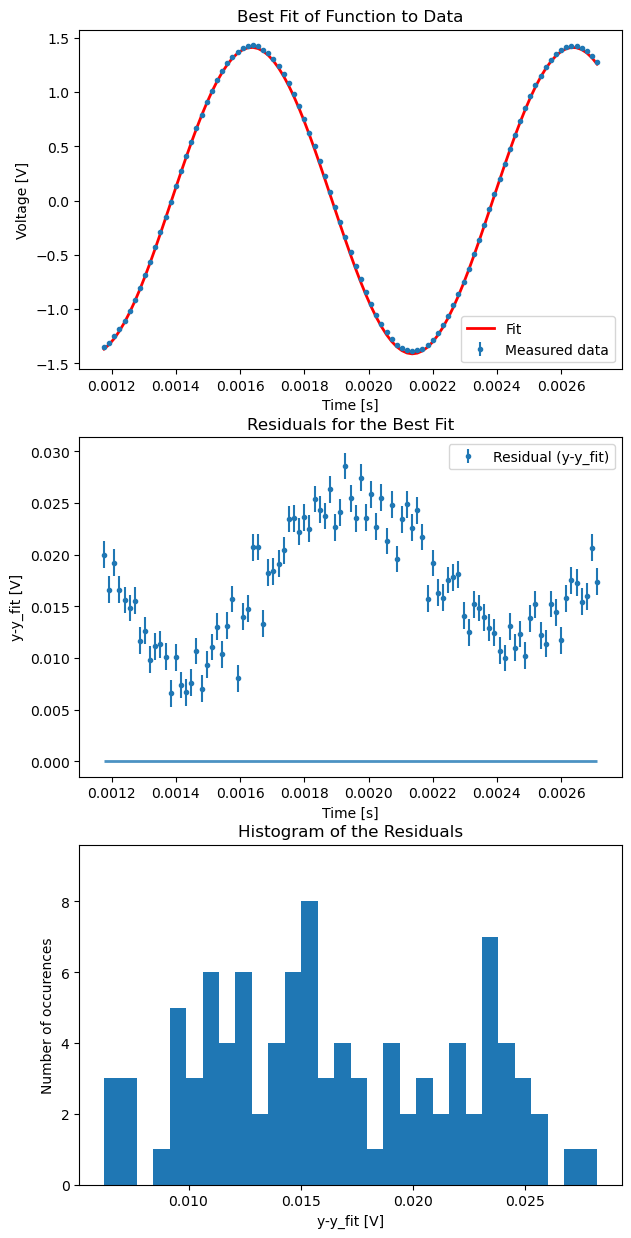

In [2]:
# Load python packages
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

###############################################################################
# DEFINED FITTING FUNCTIONS
###############################################################################

def sine_func(x, amplitude, freq, phase):
    return amplitude * np.sin(2.0 * np.pi * freq * x + phase)

def offset_sine_func(x, amplitude, freq, phase, offset):
    return (amplitude * np.sin(2.0 * np.pi * freq * x + phase)) + offset

def exponential_func(x, amplitude, tau, voffset):
    return amplitude * np.exp(x/(-1.0*tau)) + voffset

def linear_func(x, slope, intercept):
    return slope * x + intercept

###############################################################################
# LIST OF ALL INPUTS
###############################################################################

# Name of the data file
fname = "sintest2_pack.csv"

# Names and units of data columns from fname
x_name = "Time"
x_units = "s"
y_name = "Voltage"
y_units = "V"

# Modify to change the fitting function, parameter names and to set initial parameter guesses
fit_function = sine_func
param_names = ("amplitude", "frequency", "phase")
guesses = (1.0, 900, 0.1)

# Flags for optional features
show_covariance_matrix = False
set_xy_boundaries = False
lower_x = -0.01 # these values ignored if set_xy_boundaries = False
upper_x = 0.01
lower_y = -1
upper_y = 1

###############################################################################
# LOAD DATA
###############################################################################

# load the file fname and skip the first 'skiprows' rows
data = np.loadtxt(fname, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)

# Assign the data file columns to variables for later use
x = data[:, 0]
y = data[:, 2]
y_sigma = data[:, 3]

###############################################################################
# INITIAL PLOT OF THE DATA
###############################################################################

# Define 500 points spanning the range of the x-data; for plotting smooth curves
xtheory = np.linspace(min(x), max(x), 500)

# Compare the guessed curve to the data for visual reference
y_guess = fit_function(xtheory, *guesses)
plt.errorbar(x, y, yerr=y_sigma, marker=".", linestyle="", label="Measured data")
plt.plot(
    xtheory,
    y_guess,
    marker="",
    linestyle="-",
    linewidth=1,
    color="g",
    label="Initial parameter guesses",
)
plt.xlabel(f"{x_name} [{x_units}]")
plt.ylabel(f"{y_name} [{y_units}]")
plt.title(r"Comparison between the data and the intial parameter guesses")
plt.legend(loc="best", numpoints=1)
plt.show()

# calculate the value of the model at each of the x-values of the data set
y_fit = fit_function(x, *guesses)

# Residuals are the difference between the data and theory
residual = y - y_fit

# Plot the residuals
plt.errorbar(x, residual, yerr=y_sigma, marker=".", linestyle="", label="residuals")
plt.xlabel(f"{x_name} [{x_units}]")
plt.ylabel(f"Residual y-y_fit [{y_units}]")
plt.title("Residuals using initial parameter guesses")
plt.show()

###############################################################################
# PERFORM THE FIT AND PRINT RESULTS
###############################################################################

# Use curve_fit to perform the fit
# fit_function: defined above to choose a specific fitting function 
# fit_params: holds the resulting fit parameters
# fit_cov: the covariance matrix between all the parameters
#          (used to extract fitting parameter uncertanties)
# maxfev=10**5: maximum number of fitting procedure iterations before giving up
# absolute_sigma=True: uncertainties are treated as absolute (not relative)
fit_params, fit_cov = curve_fit(
    fit_function, x, y, sigma=y_sigma, 
    p0=guesses,absolute_sigma=True, maxfev=10**5)

# Define the function that calculates chi-squared
def chi_square(fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_params)
    return np.sum((y - fit_function(x, *fit_parameters)) ** 2 / sigma**2)/dof

# Calculate and print reduced chi-squared
chi2 = chi_square(fit_params, x, y, y_sigma)
print("Chi-squared = ", chi2)

# Calculate the uncertainties in the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# Print the fit parameters with uncertianties
print("\nFit parameters:")
for i in range(len(fit_params)):
    print(f"   {param_names[i]} = {fit_params[i]:.3e} ± {fit_params_error[i]:.3e}")
print("\n")

# (Optional) Print the covariance between all variables
if show_covariance_matrix:
    print("Covariance between fit parameters:")
    for i, fit_covariance in enumerate(fit_cov):
        for j in range(i+1,len(fit_covariance)):
            print(f"   {param_names[i]} and {param_names[j]}: {fit_cov[i,j]:.3e}")
    print("\n")

# residual is the difference between the data and model
x_fitfunc = np.linspace(min(x), max(x), len(x))
y_fitfunc = fit_function(x_fitfunc, *fit_params)
y_fit = fit_function(x, *fit_params)
residual = y-y_fit

###############################################################################
# PRODUCE A MULTIPANEL PLOT, WITH SCATTER PLOT, RESIDUALS AND RESIDUALS HISTOGRAM
###############################################################################

# The size of the canvas
fig = plt.figure(figsize=(7,15))

# The scatter plot
ax1 = fig.add_subplot(311)
ax1.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="Measured data")
ax1.plot(x_fitfunc, y_fitfunc, marker="", linestyle="-", linewidth=2,color="r", label="Fit")
ax1.set_xlabel(f"{x_name} [{x_units}]")
ax1.set_ylabel(f"{y_name} [{y_units}]")
ax1.set_title('Best Fit of Function to Data')

# (Optional) set the x and y boundaries of your plot
if set_xy_boundaries:
    plt.xlim(lower_x,upper_x)
    plt.ylim(lower_y,upper_y)
# Show the legend. loc='best' places it where the date are least obstructed
ax1.legend(loc='best',numpoints=1)

# The residuals plot
ax2 = fig.add_subplot(312)
ax2.errorbar(x, residual, yerr=y_sigma,marker='.', linestyle='', label="Residual (y-y_fit)")
ax2.hlines(0,np.min(x),np.max(x),lw=2,alpha=0.8)
ax2.set_xlabel(f"{x_name} [{x_units}]")
ax2.set_ylabel(f"y-y_fit [{y_units}]")
ax2.set_title('Residuals for the Best Fit')
ax2.legend(loc='best',numpoints=1)

# Histogram of the residuals
ax3 = fig.add_subplot(313)
hist,bins = np.histogram(residual,bins=30)
ax3.bar(bins[:-1],hist,width=bins[1]-bins[0])
ax3.set_ylim(0,1.2*np.max(hist))
ax3.set_xlabel(f"y-y_fit [{y_units}]")
ax3.set_ylabel('Number of occurences')
ax3.set_title('Histogram of the Residuals')

# Save a copy of the figure as a png 
plt.savefig('FittingResults.png')

# Show the plot
plt.show()